# Tensor
- http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html

In [1]:
from __future__ import division

import torch
import numpy as np

print torch.__version__
print np.__version__

0.1.12_2
1.12.1


In [2]:
x = torch.rand(5, 3)
y = torch.rand(5, 3)
x.size()

torch.Size([5, 3])

### Operation that mutates a tensor in-place is post-fixed with an _

In [3]:
x.t_()


 0.1715  0.6529  0.4707  0.3493  0.0333
 0.4325  0.4613  0.5362  0.2355  0.8739
 0.8645  0.2674  0.4960  0.9963  0.5146
[torch.FloatTensor of size 3x5]

### Indexing

In [4]:
x[:, 1]


 0.6529
 0.4613
 0.2674
[torch.FloatTensor of size 3]

### Torch Tensor <-> Numpy Array

In [5]:
x.numpy()

array([[ 0.17148094,  0.65292889,  0.47073117,  0.34932423,  0.0333273 ],
       [ 0.43251604,  0.46131712,  0.53615016,  0.23547147,  0.87386084],
       [ 0.86445421,  0.26740044,  0.496016  ,  0.99626905,  0.51456851]], dtype=float32)

In [6]:
torch.from_numpy(np.ones(5))


 1
 1
 1
 1
 1
[torch.DoubleTensor of size 5]

### CUDA Tensor

In [7]:
# dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor
torch.cuda.is_available()

True

In [8]:
x = x.cuda()
y = y.cuda()

In [9]:
x+y


 0.2820  0.8603  0.6911  0.8099  0.0381
 0.5317  0.9886  0.6538  0.9842  1.4882
 1.4340  0.7646  1.4852  1.9631  1.1121
[torch.cuda.FloatTensor of size 3x5 (GPU 0)]

---
# Autograd
- http://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

### Variable
- Access raw data (i.e., Tensor) through ```.data```, gradient through ```.grad``` attribute
- ```.backward()``` does back propagation
- Variable defined a computational graph, allowing to automatically compute gradients

In [10]:
from torch.autograd import Variable

In [11]:
x = Variable(torch.ones(2, 2), requires_grad=True)

In [12]:
y = x + 2
z = y * y * 3
o = z.mean()

In [13]:
o.backward()

In [14]:
print o.grad    # ?
print o.data

None

 27
[torch.FloatTensor of size 1]



---
# Neural Networks
- http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [16]:
class SampleNet(nn.Module):
    
    def __init__(self, channels=1):    # define layers with weights
        super(SampleNet, self).__init__()
        self.conv1 = nn.Conv2d(channels, 6, (5, 5))    # 1 input channel, 6 output channel, 5*5 kernel
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, (5, 5))
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_features(x))    # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_features(self, x):
        size = x.size()[1:]    # except batch dimension
        n = 1
        for s in size:
            n *= s
        return n        

In [17]:
net = SampleNet()
print net

SampleNet (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


In [18]:
# Forward
x = Variable(torch.randn(1, 1, 32, 32))    # NCHW
# Input:  1, 32, 32
# Conv1:  6, 28, 28
# Pool1:  6, 14, 14
# Conv2: 16, 10, 10
# Pool2: 16,  5,  5
# FC1:   400 -> 120
# FC2:   120 ->  84
# FC3:    84 ->  10
y_h = net(x)
print y_h

Variable containing:
-0.0194  0.0483  0.0484  0.0106 -0.0171  0.0614 -0.0442  0.0642 -0.1254 -0.1173
[torch.FloatTensor of size 1x10]



In [19]:
# Backward
optimizer = optim.Adam(net.parameters(), lr=1e-3)
optimizer.zero_grad()    # flush gradient buffer
y = Variable(torch.arange(1, 11))    # dummy
criterion = nn.MSELoss()
loss = criterion(y_h, y)
print loss
loss.backward()    # calc gradients
optimizer.step()    # update weight

Variable containing:
 38.8145
[torch.FloatTensor of size 1]



---
# CIFAR10
- http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [21]:
# Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5,.5,.5), (.5,.5,.5))])
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
def imshow(img):
    img = img / 2 + 0.5    # 0-1
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

torch.Size([4, 3, 32, 32])
ship


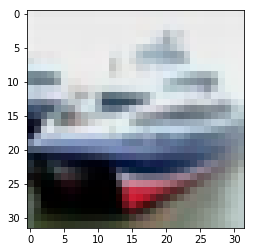

In [23]:
# Sample
dataiter = iter(testloader)
images, labels = dataiter.next()
print images.size()
print classes[labels[1]]
imshow(images[1])

In [24]:
# Model
net = SampleNet(channels=3)
net.cuda()    # use GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [25]:
# Train
for epoch in range(10):
    _loss = .0
    for step, (x, y) in enumerate(trainloader, 1):
        x, y = Variable(x.cuda()), Variable(y.cuda())
        optimizer.zero_grad()
        y_h = net(x)
        loss = criterion(y_h, y)
        loss.backward()
        optimizer.step()
        _loss += loss.data[0]    # loss itself is not scalar
        if step % 4000 == 0:
            print 'Epoch={} Step={} Loss={}'.format(epoch+1, step, _loss)
            _loss = .0

Epoch=1 Step=4000 Loss=7127.154998
Epoch=1 Step=8000 Loss=6049.67474911
Epoch=1 Step=12000 Loss=5684.34711048
Epoch=2 Step=4000 Loss=5371.61085331
Epoch=2 Step=8000 Loss=5157.32687739
Epoch=2 Step=12000 Loss=5073.66945606
Epoch=3 Step=4000 Loss=4819.9245549
Epoch=3 Step=8000 Loss=4857.22655977
Epoch=3 Step=12000 Loss=4744.05268879
Epoch=4 Step=4000 Loss=4478.69756831
Epoch=4 Step=8000 Loss=4575.83774575
Epoch=4 Step=12000 Loss=4542.27432359
Epoch=5 Step=4000 Loss=4259.81654188
Epoch=5 Step=8000 Loss=4371.06160181
Epoch=5 Step=12000 Loss=4387.04552899
Epoch=6 Step=4000 Loss=4077.10606264
Epoch=6 Step=8000 Loss=4162.47280564
Epoch=6 Step=12000 Loss=4315.80315044
Epoch=7 Step=4000 Loss=3970.78053682
Epoch=7 Step=8000 Loss=4092.53653866
Epoch=7 Step=12000 Loss=4124.91836635
Epoch=8 Step=4000 Loss=3882.19095669
Epoch=8 Step=8000 Loss=3930.22532056
Epoch=8 Step=12000 Loss=4020.91952044
Epoch=9 Step=4000 Loss=3835.6254763
Epoch=9 Step=8000 Loss=3889.30379331
Epoch=9 Step=12000 Loss=3900.39684

True: frog frog car frog
Pred: deer frog car bird


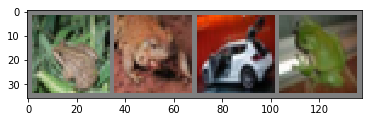

In [26]:
# Test
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
y_h = net(Variable(images.cuda()))
_, prediction = torch.max(y_h.data, 1)    # must be .data else pred becomes Variable
print 'True: '+' '.join(map(classes.__getitem__, labels))
print 'Pred: '+' '.join(map(classes.__getitem__, prediction.view(-1).tolist()))

In [27]:
# Accuracy (overall)
correct, total = 0, 0
for (images, labels) in testloader:
    y_h = net(Variable(images.cuda()))
    _, prediction = torch.max(y_h.data, 1)
    total += labels.size(0)    # size(0): [4] -> 4
    correct += (prediction == labels.cuda()).sum()    # true: 1, false: 0
print correct, total, correct / total

6082 10000 0.6082


In [28]:
# Accuracy (class)
correct = [0 for _ in range(len(classes))]
total = [0 for _ in range(len(classes))]
for (images, labels) in testloader:
    y_h = net(Variable(images.cuda()))
    _, prediction = torch.max(y_h.data, 1)
    tf = (prediction == labels.cuda()).squeeze()    # squeeze: 4*1 -> 4
    for i, j in enumerate(labels):
        correct[j] += tf[i]
        total[j] += 1
for i in range(len(classes)):
    print '{:5s}: {:.3f}'.format(classes[i], correct[i] / total[i])

plane: 0.719
car  : 0.796
bird : 0.496
cat  : 0.316
deer : 0.556
dog  : 0.505
frog : 0.805
horse: 0.613
ship : 0.575
truck: 0.701
